# 📝 🌍 CSCI 1460 Machine Translation Assignment 
In this project you will build a neural machine translation model using a Transformer encoder-decoder architecture. The primary goal of the assignment is to **implement the transformer yourself**! Outside of this class, you would likely use existing library implementations of Transformers, but for this assignment, we want you to get direct experience with the pieces that go into the full architecture.

The main learning objectives for this assignment are to:

1. Understand and implement a Transformer encoder block and a Transformer decoder block
2. Understand and implement the BLEU metric for evaluating machine translation
3. Understand the visualization of decoder attention during translation

***Make sure you're using a GPU runtime when you are training the model!*** Go to Runtime > Change runtime type to make sure you are on a GPU runtime when training these models.

# [DO NOT EDIT] Setup and Data Preprocessing

### You only need to read through and run this section. There are no coding TODOs for you. Feel free to collapse the cell with the arrow on the top left.

In [1]:
import random
import math
import copy
import io
import os

import torch
import torch.nn as nn
import numpy as np
from collections import Counter

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.utils import download_from_url, extract_archive
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from timeit import default_timer as timer

In [2]:
SEED = 42
def seed_everything(s):
  random.seed(s)
  torch.manual_seed(s)
  torch.cuda.manual_seed_all(s)
  np.random.seed(s)
  torch.backends.cudnn.deterministic = True
seed_everything(SEED)

In [3]:
!python -m spacy download en
!python -m spacy download de

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 458 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ As of spaCy v3.0, shortcuts like 'de' are deprecated. Please use the
full pipeline package name 'de_core_news_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 500 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [4]:
# data loaded from multi30k dataset
url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    for string_ in f:
      counter.update(tokenizer(string_))
  return torchtext.vocab.vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

de_vocab = build_vocab(train_filepaths[0], de_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)
de_vocab.set_default_index(0)
en_vocab.set_default_index(0)

def data_process(filepaths):
  raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
  raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
  data = []
  for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
    de_tensor_ = torch.tensor(de_vocab(de_tokenizer(raw_de)), dtype=torch.long)
    en_tensor_ = torch.tensor(en_vocab(en_tokenizer(raw_en)), dtype=torch.long)

    data.append((de_tensor_, en_tensor_))
  return data

train_data = data_process(train_filepaths)
val_data = data_process(val_filepaths)
test_data = data_process(test_filepaths)

100%|██████████| 637k/637k [00:00<00:00, 99.7MB/s]
100%|██████████| 569k/569k [00:00<00:00, 83.5MB/s]
100%|██████████| 24.7k/24.7k [00:00<00:00, 8.41MB/s]
100%|██████████| 21.6k/21.6k [00:00<00:00, 8.29MB/s]
100%|██████████| 22.9k/22.9k [00:00<00:00, 6.50MB/s]
100%|██████████| 21.1k/21.1k [00:00<00:00, 13.6MB/s]


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
PAD_IDX = de_vocab['<pad>']
BOS_IDX = de_vocab['<bos>']
EOS_IDX = de_vocab['<eos>']

def generate_batch(data_batch):
  # data_batch is a list of tuples of (de_sentence, en_sentence)
  de_batch, en_batch = [], []
  for (de_item, en_item) in data_batch:
    de_batch.append(torch.cat([torch.tensor([BOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0))
    en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
  de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
  return de_batch, en_batch

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_batch)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=False, collate_fn=generate_batch)

# Part 1: Building a Transformer
In this section, we'll implement our own Transformer model using some PyTorch implementations of attention. Transformers were introduced in 2017 by Vaswani et al. and consist of an encoder-decoder structure seen below.

First, in Part 1a, we'll implement the green encoder box, and then in Part 1b, we'll implement the pink decoder. We'll then link these modules together into a `ManualTransformer` class in Part 2c. Let's open up some boxes!

![image](https://drive.google.com/uc?id=1gsA8TgBRN020YwBSdtNUBX8xvnM-ZO93)

For more help in understanding transformers on a conceptual level, check out Jay Alammar's [illustrated transformer](https://jalammar.github.io/illustrated-transformer/), which is where the rest of the illustrations in this assignment will be coming from. 

### [DO NOT EDIT] Helper Code 

This cell includes some modules and functions. You might have to take a look at the code to see how it works, but you shouldn't need to edit any of it. **We have starred the ones that you will eventually need to use!**

Modules:
* `TokenEmbedding`, basically a PyTorch `nn.Embedding` module except it also multiplies the embeddings by $\sqrt{d_{model}}$ as specified in Vaswani et al. 2017
* `PositionalEncoding`, a PyTorch module whose forward pass adds positional encodings to the inputted embeddings
* **\*\*** **`SublayerConnection`**, a module that takes in a sublayer function (e.g. the forward pass of a feedforward layer or the forward pass of an attention module) and performs layer normalization and dropout on that sublayer
* **\*\*** **`PositionwiseFeedForward`**, a module that implements the feedforward network used throughout the Transformer

Helper functions:
* `generate_subsequent_mask(size)` which generates a mask to obscure future positions for the decoder
* `padding_mask(idx_tensor)` which takes in a tensor of word indices and outputs a mask that is `True` wherever there is padding in the given tensor
* **\*\*** **`clones(module, N)`** which takes in a module and returns a `nn.ModuleList` of N clones of that module.

In [6]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)
  
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout, maxlen = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

In [7]:
def generate_subsequent_mask(size):
    mask = (torch.triu(torch.ones((size, size), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def padding_mask(idx_tensor):
  return (idx_tensor == PAD_IDX).transpose(0, 1)

def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [8]:
def train_epoch(model, optimizer, train_dataloader, loss_fn):
    model.train()
    total_loss = 0

    for src, tgt in train_dataloader:
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:-1, :]

        src_padding_mask = padding_mask(src)
        tgt_padding_mask = padding_mask(tgt_input)

        logits = model(src, tgt_input, src_padding_mask, tgt_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_dataloader)


def val(model, val_dataloader, loss_fn):
    model.eval()
    losses = 0

    for src, tgt in val_dataloader:
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_padding_mask = padding_mask(src)
        tgt_padding_mask = padding_mask(tgt_input)

        logits = model(src, tgt_input, src_padding_mask, tgt_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

In [9]:
def train(model, loss_fn, optimizer, n_epochs=10):
  model = model.to(device)

  for epoch in range(1, n_epochs+1):
      start_time = timer()
      train_loss = train_epoch(model, optimizer, train_loader, loss_fn)
      end_time = timer()
      val_loss = val(model, val_loader, loss_fn)
      print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

## Part 1a: Building an Encoder Block

One green Transformer encoder box consists of *N* identical blocks stacked on top of each other. 
![image](https://drive.google.com/uc?id=1VTYJOtyVx1L5UORqH29mNSIX1Gz0fgd0)


To implement one of these green layers, we will create a `ManualEncoderLayer` class, and then duplicate and stack these all together in our `ManualEncoder` class.

### Implementing an Encoder Layer: `ManualEncoderLayer`
Each encoder layer consists of:
1. A self-attention sublayer (hint: `torch.nn.MultiheadAttention`)
2. A feed-forward sublayer (hint: the class we give you, `PositionWiseFeedForward`)

![image](https://drive.google.com/uc?id=1_miH3R_hRjDT-_CRFoSr_VhcbDm2o04o)


Make sure to create a new `SublayerConnection` module for each sublayer which will cleanly implement residual connections (the dotted lines and 'add' in the diagram) and layer normalization ('normalize' in the diagram) for you. For each sublayer, you will then pass a function calling either your attention module or your feed-forward module into the `SublayerConnection` forward pass. Feel free to look at the implementation for `SublayerConnection` to figure out how to use it.


In [10]:
class ManualEncoderLayer(nn.Module):
    def __init__(self, dim_emb, dropout, nhead, dim_ff):
        super(ManualEncoderLayer, self).__init__()

        #TODO: Initialize the necessary pieces of the encoder block

        self.dim_emb, self.dropout, self.nhead, self.dim_ff = dim_emb, dropout, nhead, dim_ff
        self.self_attn = nn.MultiheadAttention(
            embed_dim=dim_emb, 
            num_heads=nhead, 
            dropout=dropout
        )
        self.feed_forward = PositionwiseFeedForward(
            d_model=dim_emb, 
            d_ff=dim_ff, 
            dropout=dropout
        )
        self.sublayers = clones(SublayerConnection(size=dim_emb, dropout=dropout), 2)

    def forward(self, x, src_mask, padding_mask):
        
        #TODO: Implement the forward pass

        # A self-attention sublayer
        x = self.sublayers[0](
            x, 
            lambda x: self.self_attn(
                x, x, x, 
                attn_mask=src_mask, 
                key_padding_mask=padding_mask,
                need_weights=False
            )[0]
        ) # Only attn_output is needed

        # A feed-forward sublayer
        return self.sublayers[1](x, self.feed_forward)

        

### Implementing the Encoder: `ManualEncoder`
In the encoder itself, you want to
1. create *N* instances of the given `ManualEncoderLayer` (hint: check out the `clones` function we gave you above)
2. stack together your *N* layers in the forward pass
3. perform layer normalization (`nn.LayerNorm`) one more time at the end

In [11]:
from tarfile import XHDTYPE
class ManualEncoder(nn.Module):
    def __init__(self, layer, N):
        super(ManualEncoder, self).__init__()
        
        #TODO: Initialize the necessary pieces of the encoder 
        # (Hint, the mostly consists of making copies of your encoder layers)

        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.dim_emb)

    def forward(self, x, src_mask, padding_mask):
        
        #TODO: Implement the forward pass

        for layer in self.layers:
          x = layer(x, src_mask, padding_mask)
        return self.norm(x)



### Finishing Part 1a: Testing your Encoder

Run the below cell to make sure that your outputs match ours before moving to the next section. Your outputs should look like:
```
tensor([[ 0.7457,  0.8852,  1.0867, -1.8108,  0.8940, -0.2294, -0.5474, -1.0240],
        [-0.5925,  1.6613,  0.9158, -0.4786, -1.1084,  1.1541, -0.9447, -0.6070],
        [ 1.0442,  0.8725,  1.2680, -1.8293,  0.2005, -0.6618, -0.8446, -0.0495],
        [ 0.8902,  1.7593, -0.0814, -1.5282,  0.2167,  0.0962, -1.3084, -0.0443],
        [-0.1739,  2.1798,  0.0213, -0.8473, -0.4256,  0.4360, -1.4378,  0.2474]],
       grad_fn=<NativeLayerNormBackward0>)
```

In [12]:
### DO NOT EDIT THIS CODE ###
seed_everything(SEED)
test_encoder = ManualEncoder(ManualEncoderLayer(dim_emb=8, dropout=0.1, nhead=8, dim_ff=8), 2)
encoder_tester_srcmask = torch.zeros((5, 5)).type(torch.bool)
encoder_tester_paddingmask = torch.cat([torch.zeros((3,)), torch.ones((2,))]).type(torch.bool) # pretend the last two tokens are <pad>
encoder_tester = torch.Tensor([[0.9806, 0.0063, 0.6183, 0.1056, 0.9913, 0.5688, 0.6567, 0.1243],
        [0.5095, 0.3469, 0.7348, 0.8514, 0.4808, 0.7631, 0.6010, 0.1722],
        [0.9106, 0.3521, 0.3979, 0.0212, 0.1941, 0.0814, 0.2538, 0.0634],
        [0.7813, 0.0269, 0.1815, 0.3024, 0.1320, 0.6719, 0.6892, 0.4477],
        [0.4092, 0.4568, 0.5662, 0.5217, 0.0281, 0.4834, 0.3580, 0.5059]]) # (source sequence length=5, emb_size=8)
test_encoder.eval()
test_encoder_out = test_encoder(encoder_tester, encoder_tester_srcmask, encoder_tester_paddingmask)
print(test_encoder_out)

tensor([[ 0.7457,  0.8852,  1.0867, -1.8108,  0.8940, -0.2294, -0.5474, -1.0240],
        [-0.5925,  1.6613,  0.9158, -0.4786, -1.1084,  1.1541, -0.9447, -0.6070],
        [ 1.0442,  0.8725,  1.2680, -1.8293,  0.2005, -0.6618, -0.8446, -0.0495],
        [ 0.8902,  1.7593, -0.0814, -1.5282,  0.2167,  0.0962, -1.3084, -0.0443],
        [-0.1739,  2.1798,  0.0213, -0.8473, -0.4256,  0.4360, -1.4378,  0.2474]],
       grad_fn=<NativeLayerNormBackward0>)


## Part 1b: Building a Decoder Block
The decoder works the same way, with six identical `ManualDecoderLayer`s stacked on top of each other in our `ManualDecoder` class.

### Implementing a Decoder Layer: `ManualDecoderLayer`

A single decoder layer consists of:
1. A self-attention sublayer
2. A cross-attention sublayer (encoder-decoder attention)
3. A feed-forward sublayer 

![image](https://drive.google.com/uc?id=1oU4jlveCwWme58UUwwXs4MEGTnFOtpUA)

Again, you will want to use a bunch of `SublayerConnection` modules to handle the residual connections and layer normalizations. 

**Important:** for the analysis code we give you in Part 3, you will have to save the attention weights of the cross-attention sublayer in the variable `self.attn_weights`. Because of the sublayer setup, this will be a little weird. Do your forward pass normally, but then also separately call your cross-attention module with `need_weights=True` to get out and save the attention weights for that section. (look [here](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) for what `need_weights` actually does).

In [13]:
class ManualDecoderLayer(nn.Module):
    def __init__(self, dim_emb, dropout, nhead, dim_ff):
        super(ManualDecoderLayer, self).__init__()
        
        #TODO: Initialize the necessary pieces of the decoder block
        self.attn_weights = None 
        self.layer_dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(dim_emb)
        self.dim_emb, self.dropout, self.nhead, self.dim_ff = dim_emb, dropout, nhead, dim_ff
        self.self_attn = nn.MultiheadAttention(
            embed_dim=dim_emb, 
            num_heads=nhead, 
            dropout=dropout
        )
        self.src_attn = nn.MultiheadAttention(
            embed_dim=dim_emb, 
            num_heads=nhead, 
            dropout=dropout
        )
        self.feed_forward = PositionwiseFeedForward(
            d_model=dim_emb, 
            d_ff=dim_ff, 
            dropout=dropout
        )
        self.sublayers = clones(SublayerConnection(size=dim_emb, dropout=dropout), 2) # I implemented SublayerConnection for src_att separately


    def forward(self, x, memory, src_padding_mask, tgt_mask, tgt_padding_mask):
      
        #TODO: Implement the forward pass
        
        # A self-attention sublayer
        x = self.sublayers[0](
            x, 
            lambda x: self.self_attn(
                x, x, x, 
                attn_mask=tgt_mask, 
                key_padding_mask=tgt_padding_mask, 
                need_weights=False
            )[0] # (Tensor, None)
        ) 
 
        # A cross-attention sublayer (encoder-decoder attention)
        # Implement a new SublayerConnection to obtain attn_output and attn_output_weights
        x_ = self.layer_norm(x)
        x_, weights = self.src_attn(
            x_, memory, memory, 
            key_padding_mask=src_padding_mask, 
            need_weights=True
        )
        x_ = self.layer_dropout(x_)
        x = x + x_
        
        #TODO: save the cross-attention weights here
        self.attn_weights = weights

        # A feed-forward sublayer
        return self.sublayers[1](x, self.feed_forward) 

       

### Implementing the Decoder: `ManualDecoder`
Now, we can combine as many decoder layers as we want in our decoder class, which should look very similar to our `ManualEncoder` class.

1. create *N* instances of the given `ManualDecoderLayer` (hint: check out the `clones` function we gave you above)
2. stack together your *N* layers in the forward pass
3. perform layer normalization (`nn.LayerNorm`) one more time at the end

In [14]:
class ManualDecoder(nn.Module):
    def __init__(self, layer, N):
        super(ManualDecoder, self).__init__()

        #TODO: Initialize the necessary pieces of the decoder 
        # (Hint, the mostly consists of making copies of your decoder layers)

        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.dim_emb)

    def forward(self, x, memory, src_padding_mask, tgt_mask, tgt_padding_mask):

        #TODO: Implement the forward pass

        for layer in self.layers:
          x = layer(x, memory, src_padding_mask, tgt_mask, tgt_padding_mask)
        return self.norm(x)

### Finishing Part 1b: Testing your Decoder

If you've implemented your decoder correctly, the output of the below cell should look like this:

```
tensor([[ 1.2406, -0.9287,  1.3650, -1.3399,  0.1385, -0.9783,  0.8983, -0.3955],
        [ 0.9685,  0.0181,  1.3477, -2.1036,  0.1635, -0.3701,  0.5607, -0.5848],
        [ 0.6339,  1.2617, -1.0904, -1.2991,  0.8132,  0.0155,  0.9308, -1.2656],
        [ 1.3019, -0.2461,  0.5263, -0.8281,  0.1514, -1.2825,  1.5194, -1.1424],
        [ 0.7919, -0.3827,  0.8741, -0.8170,  0.7603, -0.9159,  1.3159, -1.6267],
        [ 1.4759,  0.0240,  0.0938, -1.4089,  0.2116, -0.7633,  1.4349, -1.0681]],
       grad_fn=<NativeLayerNormBackward0>)
```

This test will work regardless of whether you have implemented your encoder yet.


In [15]:
### DO NOT EDIT THIS CODE ###
seed_everything(SEED)
test_decoder = ManualDecoder(ManualDecoderLayer(dim_emb=8, dropout=0.1, nhead=8, dim_ff=8), 2)
decoder_tester_srcmask = torch.zeros((5,)).type(torch.bool)
decoder_tester_tgtmask = generate_subsequent_mask(6).to("cpu")
decoder_tester_tgtpaddingmask = torch.cat([torch.zeros((5,)), torch.ones((1,))]).type(torch.bool) # pretend the last token is <pad>
decoder_tester = torch.Tensor([[0.5398, 0.2187, 0.2749, 0.6701, 0.0616, 0.4221, 0.4889, 0.2974],
        [0.6820, 0.5322, 0.8510, 0.4556, 0.1844, 0.8533, 0.5698, 0.3568],
        [0.1704, 0.6172, 0.0231, 0.6317, 0.7472, 0.0614, 0.1727, 0.1405],
        [0.9203, 0.9251, 0.5313, 0.9694, 0.3328, 0.0146, 0.6746, 0.6771],
        [0.9902, 0.4999, 0.8832, 0.8065, 0.8619, 0.0038, 0.9117, 0.0738],
        [0.9483, 0.4793, 0.0569, 0.6390, 0.3982, 0.0509, 0.3187, 0.5516]]) # (source sequence length=6, emb_size=8)
m = torch.Tensor([[ 5.1795e-02, -3.3640e-01, -7.0393e-01, -7.7838e-01,  2.3397e+00, -2.0453e-03, -1.0419e+00,  4.7115e-01],
        [-1.1013e+00,  1.6081e+00, -1.1974e+00,  1.2322e+00, -6.1193e-01, 7.6468e-01, -5.0261e-01, -1.9163e-01],
        [ 8.5518e-01,  1.1917e+00, -4.1526e-01, -1.5853e+00, -1.8449e-01, -9.6848e-01, -3.3488e-01,  1.4416e+00],
        [-1.3389e-01,  1.1363e+00, -2.2511e+00,  3.1282e-02, -2.9551e-01, 1.4653e-01,  1.4476e-01,  1.2216e+00],
        [-8.5308e-01,  1.8265e+00, -1.3266e+00,  3.6617e-01, -6.4322e-01, 1.4753e-01, -6.2170e-01,  1.1044e+00]]) # test_encoder_out 

test_decoder.eval()
print(test_decoder(decoder_tester, m, decoder_tester_srcmask, decoder_tester_tgtmask, decoder_tester_tgtpaddingmask))

tensor([[ 1.2406, -0.9287,  1.3650, -1.3399,  0.1385, -0.9783,  0.8983, -0.3955],
        [ 0.9685,  0.0181,  1.3477, -2.1036,  0.1635, -0.3701,  0.5607, -0.5848],
        [ 0.6339,  1.2617, -1.0904, -1.2991,  0.8132,  0.0155,  0.9308, -1.2656],
        [ 1.3019, -0.2461,  0.5263, -0.8281,  0.1514, -1.2825,  1.5194, -1.1424],
        [ 0.7919, -0.3827,  0.8741, -0.8170,  0.7603, -0.9159,  1.3159, -1.6267],
        [ 1.4759,  0.0240,  0.0938, -1.4089,  0.2116, -0.7633,  1.4349, -1.0681]],
       grad_fn=<NativeLayerNormBackward0>)


## Part 1c: Putting Everything Together

Finally, we can implement the last few details. We've already taken care of mostly everything on here (recognize the multi-head attention, layer normalization, and feed-forward networks)?

![image](https://drive.google.com/uc?id=1Rr9ezcbbW8UAaTSfY-7snHeKrVJHAyoz)

There's just a few more things to take care of. In our `ManualTransformer` class, we've put together your encoder and decoder and added token embeddings, positional encodings, and a linear layer `out` to project from the embeddings to the target vocabulary. You'll have to use these pieces to implement `encode` and `decode`, then call these two in `forward`. 

If you are confused as to what token embeddings or positional encodings do, look at the [DO NOT EDIT] section above for a description of these modules.

In [16]:
class ManualTransformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, emb_size, nhead, 
                 src_vocab_size, tgt_vocab_size, dim_feedforward = 512, dropout = 0.1):
        super(ManualTransformer, self).__init__()
        self.encoder = ManualEncoder(ManualEncoderLayer(emb_size, dropout, nhead, dim_feedforward), num_encoder_layers)
        self.decoder = ManualDecoder(ManualDecoderLayer(emb_size, dropout, nhead, dim_feedforward), num_decoder_layers)
        self.src_embed = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_embed = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout)
        self.out = nn.Linear(emb_size, tgt_vocab_size)

        # Initialize parameters with Glorot / fan_avg.
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def get_src_mask(self, src):
        return torch.zeros((src.shape[0], src.shape[0]),device=device).type(torch.bool)

    def get_tgt_mask(self, tgt):
        return generate_subsequent_mask(tgt.shape[0])
    
    def encode(self, src, src_padding_mask):
        #TODO Implement the encode function
        src_mask = self.get_src_mask(src)
        return self.encoder(
            self.positional_encoding(self.src_embed(src)), 
            src_mask, 
            src_padding_mask
        )
    
    def decode(self, tgt, memory, src_padding_mask, tgt_padding_mask):
        #TODO Implement the decode function
        tgt_mask = self.get_tgt_mask(tgt)
        return self.decoder(
            self.positional_encoding(self.tgt_embed(tgt)), 
            memory, 
            src_padding_mask, 
            tgt_mask, 
            tgt_padding_mask
        )
    
    def forward(self, src, tgt, src_padding_mask, tgt_padding_mask):
        #TODO Implement the forward pass
        return self.out(
            self.decode(
                tgt, 
                self.encode(src, src_padding_mask), 
                src_padding_mask, 
                tgt_padding_mask
            )
        )


### Training the Model 

Here, we'll write the code to actually train and evaluate our `ManualTransformer`. First, you can sanity check and verify that your model is training properly by training for an epoch and making sure that the results look like this (it's okay if the epoch time is different, just make sure the losses are about the same):

```
Epoch: 1, Train loss: 3.999, Val loss: 3.041, Epoch time = 46.511s
```
Once you're sure the model works, you can train it for 15 epochs and proceed to the next section.

In [17]:
seed_everything(SEED)
manual_transformer = ManualTransformer(num_encoder_layers=3, num_decoder_layers=3, emb_size=512, nhead=8, src_vocab_size=len(de_vocab), tgt_vocab_size=len(en_vocab))
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(manual_transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
train(manual_transformer, loss_fn, optimizer, n_epochs=15)

Epoch: 1, Train loss: 3.992, Val loss: 3.034, Epoch time = 47.853s
Epoch: 2, Train loss: 2.814, Val loss: 2.492, Epoch time = 42.869s
Epoch: 3, Train loss: 2.351, Val loss: 2.164, Epoch time = 41.742s
Epoch: 4, Train loss: 2.047, Val loss: 2.001, Epoch time = 41.929s
Epoch: 5, Train loss: 1.824, Val loss: 1.884, Epoch time = 41.738s
Epoch: 6, Train loss: 1.653, Val loss: 1.813, Epoch time = 41.831s
Epoch: 7, Train loss: 1.513, Val loss: 1.757, Epoch time = 41.844s
Epoch: 8, Train loss: 1.396, Val loss: 1.744, Epoch time = 41.735s
Epoch: 9, Train loss: 1.296, Val loss: 1.711, Epoch time = 41.755s
Epoch: 10, Train loss: 1.203, Val loss: 1.711, Epoch time = 41.824s
Epoch: 11, Train loss: 1.126, Val loss: 1.695, Epoch time = 41.907s
Epoch: 12, Train loss: 1.054, Val loss: 1.708, Epoch time = 41.868s
Epoch: 13, Train loss: 0.989, Val loss: 1.733, Epoch time = 41.722s
Epoch: 14, Train loss: 0.930, Val loss: 1.746, Epoch time = 41.886s
Epoch: 15, Train loss: 0.874, Val loss: 1.757, Epoch time

# Part 2: Evaluating our Transformer

BLEU is a metric between zero and one that measures the quality of a machine translation against a set of high-quality "ground truth" reference translations. It is almost impossible to get a perfect score of 1, even for human translators, but it has been shown that BLEU scores correlate with human evaluations of quality. It's difficult to compare BLEU metrics across corpora, but a score of about 30% is generally considered decent.


## Part 2a: Getting Translations Out of Our Model
Before we can actually calculate BLEU though, we've provided some code to get outputs from the model.

### [DO NOT EDIT] Greedy decoding to get outputs
Here we've given you some code to get predictions from the trained model. Here's a description of the important functions:
- `tokenlist_to_strlist(tokens, vocab)`, which takes in a list of tokens and outputs a list of the strings that correspond to each token
- `tokenlist_to_str(tokens, vocab, show_pad=False)`, which calls the function above and then turns the resulting list of strings into a single sentence. If `show_pad` is True, prints out the \<pad\> tokens.
- `translate_tokens(model, src_tokens)`, which takes in a Transformer model and tokens for a German source sentence and outputs a list of tokens that are an English translation of the sentence 
- `translate(model, src_sentence)`, which takes in a Transformer model and a German source sentence as a string, and returns a string English translation.

In [18]:
# helper function to convert list of tokens to list of strings
def tokenlist_to_strlist(tokens, vocab):
  return vocab.lookup_tokens(list(tokens.cpu().numpy()))

# helper function to convert list of tokens to a string
def tokenlist_to_str(tokens, vocab, show_pad=False):
  out = " ".join(tokenlist_to_strlist(tokens, vocab)).replace("<bos>", "").replace("<eos>", "")
  if show_pad:
    return out
  else:
    return out.replace("<pad>", "")

# function to generate translation using greedy algorithm
def greedy_decode(model, src, max_len, start_symbol):
    src = src.to(device)
    src_padding_mask = padding_mask(src)

    memory = model.encode(src, src_padding_mask).to(device)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        tgt_padding_mask = padding_mask(ys)
        out = model.decode(ys, memory, src_padding_mask, tgt_padding_mask).to(device) # shape (i+1, 1, 512)
        out = out.transpose(0, 1).to(device)
        prob = model.out(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys.flatten()

# function that translates from a list of tokens to another list of tokens
def translate_tokens(model, src_tokens):
    model.eval()
    src_tokens = torch.cat([torch.tensor([BOS_IDX]), src_tokens, torch.tensor([EOS_IDX])], dim=0).view(-1, 1)
    num_tokens = src_tokens.shape[0]
    tgt_tokens = greedy_decode(model, src_tokens, max_len=num_tokens + 5, start_symbol=BOS_IDX)
    return tgt_tokens

# function that translates from a string sentence to a string version of the translation
def translate(model, src_sentence, output_tokens=False):
    model.eval()
    src_tokens = torch.tensor(de_vocab(de_tokenizer(src_sentence)), dtype=torch.long)  
    tgt_tokens = translate_tokens(model, src_tokens)
    translation = tokenlist_to_str(tgt_tokens, en_vocab)
    if output_tokens:
      return translation, src_tokens, tgt_tokens
    else:
      return translation

### Take a look at the outputs!
In this cell, we encourage you to try some sentences in German to see how well the model does at translating them into English! You can even take some examples from `val_data` yourself to test on. `val_data` is a list of `(de_tokenlist, en_tokenlist)` tuples which you can convert to strings using one of the functions above.

You can also change around the number of epochs the model trains for and see how that impacts qualitative performance. Just make sure to change it back after before handing things in.


In [19]:
print(translate(manual_transformer, "Ein Mann auf einem Maisfeld mit einem Hund"))
print(translate(manual_transformer, "Drei Kinder essen Eis, während ein Elternteil zuschaut"))
print(translate(manual_transformer, "Eine Frau am Strand fotografiert das Meer"))
print(translate(manual_transformer, "Ein Traktor bewegt Erde für den Bau einer Stützmauer."))

 A man on a dirt hill with a dog 
 
 Three children are ice cream while a flower fountain watches . 
 
 A woman at the beach is taking pictures of the ocean . 

 A tractor moving dirt for the rest of a construction site . 
 


## Part 2b: Evaluating Translations using BLEU

### Implement BLEU
The overall formula for BLEU looks like this:
$ \text{BLEU} = \min(1, \text{exp}(1 - \frac{\text{reference length}}{\text{output length}}))(\prod\limits_{i=1}^{4} precision_{i})^{1/4}$


To break it down, you have 
- a **brevity penality** on the left:
$\min(1, \text{exp}(1 - \frac{\text{reference length}}{\text{output length}}))$
- **n-gram precisions** for all of the sentences against the ground truth translations, from unigrams to 4-grams. For $i$ from $1$ to $4$, we calculate $precision_i$, which you can find a formula for below.


To calculate $precision_i$, follow the below formula, 
$precision_i = \cfrac{\sum{_{snt\in candidates}}\sum{_{igram\in snt}}\text{min}(m^i_{snt}, m^i_{ref})}{w_i}$ 

where $w_i$ is the total count of $i$-grams in all of the candidate sentences, $m^i_{snt}$ is the count of a unique $i$-gram in $snt$ and $m^i_{ref}$ is the count of that $i$-gram in the corresponding reference sentence.

Read more about how to calculate BLEU [here](https://cloud.google.com/translate/automl/docs/evaluate#bleu).

In [20]:
import math
from collections import Counter

# list_reference is a list of sentences and list_candidate is a list of sentences
# where each sentence is a list of tokens (integers or strings). 
def my_corpus_bleu(list_reference, list_candidate, n=4):
    #TODO: Implement the BLEU algorithm

    # list of words -> a collection of i-grams
    def get_ngrams(words, i):
      ngrams = []
      # print(words)
      words = list(map(str, words))
      for j in range(len(words) - i + 1):
          ngrams.append(" ".join(words[j : j + i]))
      return ngrams 

    precision = 1
    for i in range(1, n+1):
      numerator, denominator = 0, 0
      for ref, can in zip(list_reference, list_candidate):
        ref_ngrams, can_ngrams = get_ngrams(ref, i), get_ngrams(can, i) # Get i-grams
        ref_counter, can_counter = Counter(ref_ngrams), Counter(can_ngrams) # Initializa counters
        # print(ref_counter)
        # print(can_counter)
        for can_ngram in set(can_ngrams):
          numerator += min(can_counter[can_ngram], ref_counter.get(can_ngram, 0))
        denominator += len(can_ngrams)
      precision *= numerator/denominator # Get precision for this i-grams
      # print("{}-gram with precision {}".format(i, numerator/denominator))

    len_refs, len_cans = sum(list(map(len, list_reference))), sum(list(map(len, list_candidate)))
    brevity_penalty = min(1, math.exp(1-len_refs/len_cans)) 
    BLEU = brevity_penalty * pow(precision, 1/n)

    return BLEU

# toy_references3 = ["once there was a way to get back homeward".split()]
# toy_hypothesis3 = ["once once once there was a way there was a way".split()]
# my_corpus_bleu(toy_references3, toy_hypothesis3)



### Check your implementation
Here are some unit tests you can use to evaluate your implementation against the NLTK implementation (they should be almost the exact same value, within at least 4 decimal points). 

In [21]:
from nltk.translate.bleu_score import corpus_bleu

toy_references1 = ["The NASA Opportunity rover is battling a massive dust storm on Mars .".split()]
toy_hypothesis1 = ["A NASA rover is fighting a massive storm on Mars .".split()]

toy_references2 = ["The quick brown fox jumped over the lazy dog".split(), "holy crap today is fring friday".split(), "jesse we have to cook". split()]
toy_hypothesis2 = ["The fast maroon fox jumped over the tired old dog".split(), "oh wow today is fring friday".split(), "jesse we need to cook".split()]

toy_references3 = ["once there was a way to get back homeward".split()]
toy_hypothesis3 = ["once once once there was a way there was a way".split()]

def compare_bleu(toy_references, toy_hypothesis):
  print("NLTK:", corpus_bleu([[lst] for lst in toy_references], toy_hypothesis))
  print("Mine:", my_corpus_bleu(toy_references, toy_hypothesis, 4))

compare_bleu(toy_references1, toy_hypothesis1)
print()
compare_bleu(toy_references2, toy_hypothesis2)
print()
compare_bleu(toy_references3, toy_hypothesis3)

NLTK: 0.27221791225495623
Mine: 0.27221791225495623

NLTK: 0.33875516543640977
Mine: 0.3387551654364098

NLTK: 0.3508439695638686
Mine: 0.3508439695638686


### How does our model stack up?
Here we use your BLEU metric to evaluate your model! If you want, feel free to uncomment the line where we use NLTK (but if the above tests work then this will work too). 

In [22]:
def get_nltk_bleu(model, val_data, en_vocab):
  predictions = [translate_tokens(model, t[0]).tolist()[1:-1] for t in val_data]
  labels = [[t[1].tolist()] for t in val_data] # labels is a list of lists of words 
  return corpus_bleu(labels, predictions)

def get_my_bleu(model, val_data, en_vocab):
  predictions = [translate_tokens(model, t[0]).tolist()[1:-1] for t in val_data]
  labels = [t[1].tolist() for t in val_data] # labels is a list of words
  return my_corpus_bleu(labels, predictions)

print(get_nltk_bleu(manual_transformer, val_data, en_vocab))
print(get_my_bleu(manual_transformer, val_data, en_vocab))

0.3813579494747221
0.3813579494747221


# Part 3: Analysis and Conceptual Questions

In this section, we've given you a function that takes the cross-attention weights you saved in the `ManualDecoderLayer` forward pass and visualizes them. Call `analyze_sentence` and input a German sentence as a string to get a heatmap of the last layer of the decoder in the cross-attention sublayer.

In [23]:
import matplotlib.pyplot as plt
def plot_attention(src_tokens, tgt_tokens, attn_weights):
    fig = plt.figure()
    attn_weights = attn_weights.cpu()
    cax = plt.matshow(attn_weights.detach().numpy(), cmap='bone')

    src_labels = ['<bos>'] + de_vocab.lookup_tokens(list(src_tokens.cpu().numpy())) + ['<eos>']
    tgt_labels = en_vocab.lookup_tokens(list(tgt_tokens.cpu().numpy()))[1:]

    plt.xticks(range(len(src_labels)), src_labels, rotation=80)
    plt.yticks(range(len(tgt_labels)), tgt_labels)

    plt.show()

def analyze_sentence(original):
  translation, src_tokens, tgt_tokens = translate(manual_transformer, original, output_tokens=True)
  attn_weights = manual_transformer.decoder.layers[-1].attn_weights.squeeze()

  plot_attention(src_tokens, tgt_tokens, attn_weights)

Input:      Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Candidate:  A group of men are loading something into a truck .
Reference:  A group of men are loading cotton onto a truck


<Figure size 432x288 with 0 Axes>

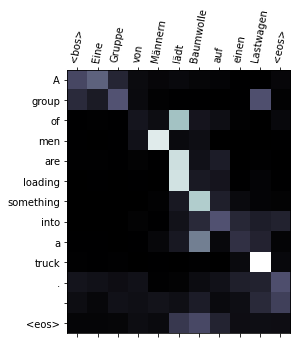

---------------------------------------------------------------------
Input:      Ein Mann schläft in einem grünen Raum auf einem Sofa.
Candidate:  A man is sleeping in a green room on a couch .
Reference:  A man sleeping in a green room on a couch.


<Figure size 432x288 with 0 Axes>

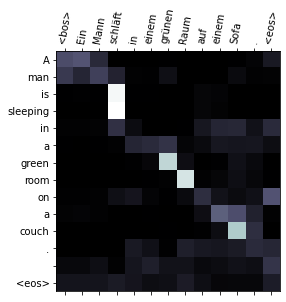

---------------------------------------------------------------------
Input:      Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
Candidate:  A boy wearing headphones sits on his shoulders to a woman 's shoulders .
Reference:  A boy wearing headphones sits on a woman's shoulders.


<Figure size 432x288 with 0 Axes>

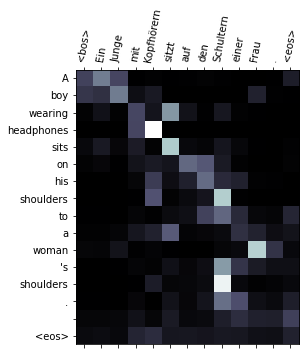

---------------------------------------------------------------------
Input:      Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf
Candidate:  Two men are building a blue raft on a basketball court .
Reference:  Two men setting up a blue ice fishing hut on an iced over lake


<Figure size 432x288 with 0 Axes>

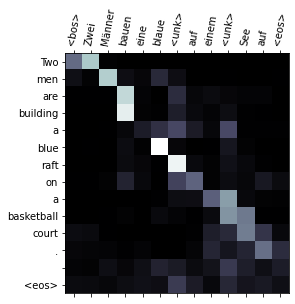

---------------------------------------------------------------------
Input:      Ein Mann mit beginnender Glatze, der eine rote Rettungsweste trägt, sitzt in einem kleinen Boot.
Candidate:  A balding man wearing a red life jacket sits in a small boat .
Reference:  A balding man wearing a red life jacket is sitting in a small boat.


<Figure size 432x288 with 0 Axes>

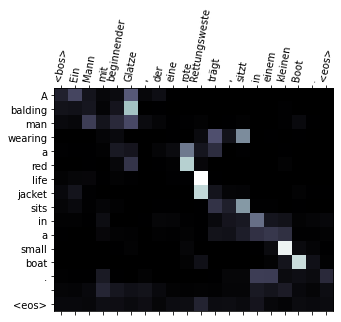

---------------------------------------------------------------------
Input:      Eine Frau in einem rotem Mantel, die eine vermutlich aus Asien stammende Handtasche in einem blauen Farbton hält, springt für einen Schnappschuss in die Luft.
Candidate:  A woman in a red coat , holding an odd purse for an Asian crowd of cooking in a blue court setting up photo .
Reference:  A lady in a red coat, holding a bluish hand bag likely of asian descent, jumping off the ground for a snapshot.


<Figure size 432x288 with 0 Axes>

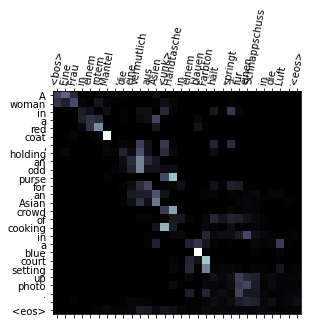

---------------------------------------------------------------------
Input:      Ein brauner Hund rennt dem schwarzen Hund hinterher.
Candidate:  A brown dog runs after the black dog .
Reference:  A brown dog is running after the black dog.


<Figure size 432x288 with 0 Axes>

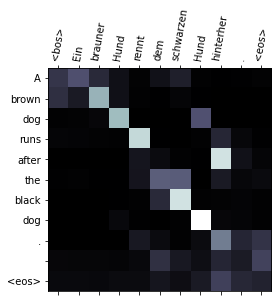

---------------------------------------------------------------------
Input:      Ein kleiner Junge mit einem Giants-Trikot schwingt einen Baseballschläger in Richtung eines ankommenden Balls.
Candidate:  A little boy wearing a purple uniform swings a baseball bat towards an ball from an opponent .
Reference:  A young boy wearing a Giants jersey swings a baseball bat at an incoming pitch.


<Figure size 432x288 with 0 Axes>

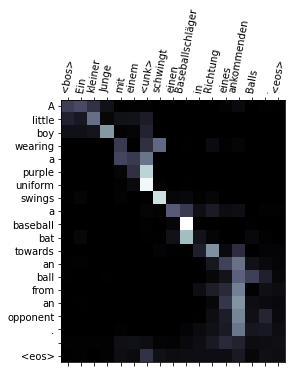

---------------------------------------------------------------------
Input:      Ein Mann telefoniert in einem unaufgeräumten Büro
Candidate:  A man is talking on the phone in an office setting .
Reference:  A man in a cluttered office is using the telephone


<Figure size 432x288 with 0 Axes>

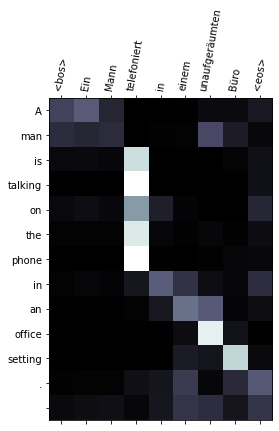

---------------------------------------------------------------------
Input:      Eine lächelnde Frau mit einem pfirsichfarbenen Trägershirt hält ein Mountainbike
Candidate:  A smiling woman wearing a peach tank top holds a mountain bike .
Reference:  A smiling woman in a peach tank top stands holding a mountain bike


<Figure size 432x288 with 0 Axes>

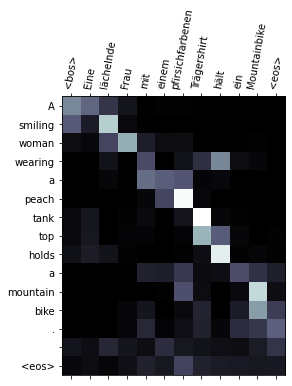

---------------------------------------------------------------------


In [24]:
# Try out different sentences here! 
# Here, I tested top-10 German sentences in the Multi30k dataset online and 
# compared them with its corresponding reference translated by professional 
# English-German translators
sentences_German = [
    "Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen",
    "Ein Mann schläft in einem grünen Raum auf einem Sofa.",
    "Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.",
    "Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf",
    "Ein Mann mit beginnender Glatze, der eine rote Rettungsweste trägt, sitzt in einem kleinen Boot.",
    "Eine Frau in einem rotem Mantel, die eine vermutlich aus Asien stammende Handtasche in einem blauen Farbton hält, springt für einen Schnappschuss in die Luft.",
    "Ein brauner Hund rennt dem schwarzen Hund hinterher.",
    "Ein kleiner Junge mit einem Giants-Trikot schwingt einen Baseballschläger in Richtung eines ankommenden Balls.",
    "Ein Mann telefoniert in einem unaufgeräumten Büro",
    "Eine lächelnde Frau mit einem pfirsichfarbenen Trägershirt hält ein Mountainbike",
]
sentences_English = [
    "A group of men are loading cotton onto a truck",
    "A man sleeping in a green room on a couch.",
    "A boy wearing headphones sits on a woman's shoulders.",
    "Two men setting up a blue ice fishing hut on an iced over lake",
    "A balding man wearing a red life jacket is sitting in a small boat.",
    "A lady in a red coat, holding a bluish hand bag likely of asian descent, jumping off the ground for a snapshot.",
    "A brown dog is running after the black dog.",
    "A young boy wearing a Giants jersey swings a baseball bat at an incoming pitch.",
    "A man in a cluttered office is using the telephone",
    "A smiling woman in a peach tank top stands holding a mountain bike",

]

for sg, se in zip(sentences_German, sentences_English):
  print("Input:     ", sg)
  print("Candidate: ",translate(manual_transformer, sg).strip())
  print("Reference: ",se)
  analyze_sentence(sg)
  print("---------------------------------------------------------------------")


## Conceptual Questions
Using the functions above, 
- Translate the sentence "*Drei Kinder essen Eis, während ein Elternteil zuschaut*" into English and look at the attention map. In English, this sentence means "Three kids eat ice cream, while a parent watches."
- Translate the sentence "*Ich esse gerne Eis mit meinen Kindern"*" into English and look at the attention map. In 
English, this sentence means "I like to eat ice cream with my kids."

1. Compare the quality of the translations of these sentences, using the attention maps as an aid, and try translating other German sentences as well. What is the difference between the attention maps for correct and less correct translations?

2. Try looking up the paper for the Multi30k dataset online, and see where our language data came from. Does that provide an explanation for why some sentences have better translations than others? Would this model work very well for translating something like a text conversation?

Input:      Drei Kinder essen Eis, während ein Elternteil zuschaut
Candidate:  Three children are ice cream while a flower fountain watches .
Reference:  Three kids eat ice cream, while a parent watches.


<Figure size 432x288 with 0 Axes>

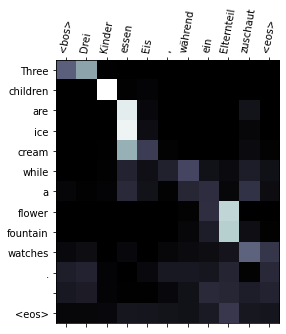

---------------------------------------------------------------------
Input:      Ich esse gerne Eis mit meinen Kindern
Candidate:  I I see ice cream children who are showing children .
Reference:  I like to eat ice cream with my kids.


<Figure size 432x288 with 0 Axes>

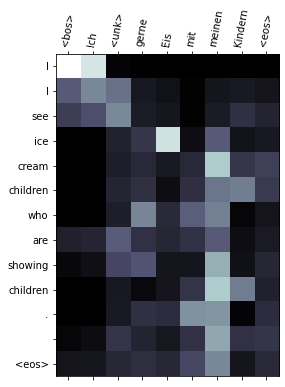

---------------------------------------------------------------------


In [25]:
# TODO use functions above to answer conceptual questions 

sentences_German = [
    "Drei Kinder essen Eis, während ein Elternteil zuschaut",
    "Ich esse gerne Eis mit meinen Kindern",
]
sentences_English = [
    "Three kids eat ice cream, while a parent watches.",
    "I like to eat ice cream with my kids.",
]

for sg, se in zip(sentences_German, sentences_English):
  print("Input:     ", sg)
  print("Candidate: ",translate(manual_transformer, sg).strip())
  print("Reference: ",se)
  analyze_sentence(sg)
  print("---------------------------------------------------------------------")


**Answers for Conceptual Questions**
<!-- 1. Compare the quality of the translations of these sentences, using the attention maps as an aid, and try translating other German sentences as well. What is the difference between the attention maps for correct and less correct translations? -->

1.  Generally, the quality of the first translation output is better than that of the second output. Compared with the provided reference, the first sentence generally performs well, except that 'essen' and 'Elternteil' is not translated correctly. However, for the second sentence, only a few nouns are translated correctly, and the whole translation is not organized and not logical. By comparing the attention maps, we could see that the diagonal pixels in first figure is relatively clear. In contrast, the second attention map's diagonal pixels are ambiguous and vague.

<!-- 2. Try looking up the paper for the Multi30k dataset online, and see where our language data came from. Does that provide an explanation for why some sentences have better translations than others? Would this model work very well for translating something like a text conversation? -->

2. According to the paper "Multi30K: Multilingual English-German Image Descriptions", the dataset is an extension of the Flickr30K dataset with German translations of English descriptions collected from professional translators and German descriptions collected from untrained crowdworkers. 

  Some sentences have better translatioins than others in that the German translations are sentence-level aligned. The translations contain approximately the same number of tokens and have sentences of approximately the same length in English and German languages. These properties make them suited to machine translations models.

  The model may not work well for translating texts from conversations, since the dataset was generated by describing the content of images and the model trained on it contains many multimodal features. Therefore, the model is suitable for research on tasks like automatic image description, image–sentence ranking, multimodal and multilingual semantics. However, for text conversation, it contains a lot of historical information in the back-and-forth dialogs. The model trained on Multi30K is not able to capture those contextual features. Also, some text conversations are 'versatile' and 'un-structured', which are different from formal languages in Multi30K. For example, when I tested the sentences using the sentences in the online dataset, I found the model tends to translate sentences using present continuous tense, because the training data is used to describle an image scenario. However, text conversations may contain different tenses.



